# Notebook 3: Target Match Feature Engineering

## Goal
Create point-by-point features with running statistics for the 2024 target match.

## Key Features to Engineer
1. **Running First Serve %**: Cumulative first serve % at each point (with Bayesian smoothing for early points)
2. **Running Ace Rate**: Cumulative ace rate at each point
3. **Historical Baselines**: Fixed values from 2023 priors (for deviation calculation)

## CRITICAL
- Keep all features on **natural 0-1 scale** (probabilities)
- DO NOT z-score (would create dimensional mismatch in Notebook 4)
- Apply Bayesian smoothing for first 10 serves (blend with historical mean)

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Imports successful")

✅ Imports successful


In [2]:
# Paths
DATA_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/data')
SRC_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/src')
CORRECTED_DIR = Path('/Users/egeaydin/Github/TUW2025WS/aip_ege/data/corrected')

# Load 2024 data
points_2024 = pd.read_csv(CORRECTED_DIR / '2024-wimbledon-points-corrected.csv')
matches_2024 = pd.read_csv(DATA_DIR / '2024-wimbledon-matches.csv')

# Load outputs from previous notebooks
with open(SRC_DIR / 'exploration_data.pkl', 'rb') as f:
    exploration = pickle.load(f)

with open(SRC_DIR / 'priors_2023.pkl', 'rb') as f:
    priors = pickle.load(f)

# Extract key variables
TARGET_MATCH_ID = exploration['target_match_id']
player1 = exploration['player1']
player2 = exploration['player2']

print(f"Target Match: {TARGET_MATCH_ID}")
print(f"Players: {player1} vs {player2}")

Target Match: 2024-wimbledon-1501
Players: Jannik Sinner vs Daniil Medvedev


## 2. Load Target Match & Player Mapping

In [3]:
# Filter for target match
target_match = points_2024[points_2024['match_id'] == TARGET_MATCH_ID].copy().reset_index(drop=True)

print(f"Total points in target match: {len(target_match)}")

# Get match metadata to determine player positions
match_meta = matches_2024[matches_2024['match_id'] == TARGET_MATCH_ID].iloc[0]

# Determine player mapping
if match_meta['player1'] == player1:
    print(f"\nPlayer Mapping:")
    print(f"  P1 (position 1) = {player1}")
    print(f"  P2 (position 2) = {player2}")
    player_position = {player1: 1, player2: 2}
else:
    print(f"\nPlayer Mapping:")
    print(f"  P1 (position 1) = {player2}")
    print(f"  P2 (position 2) = {player1}")
    player_position = {player1: 2, player2: 1}

# Display first few points
print("\nFirst 5 points:")
target_match[['PointNumber', 'PointServer', 'PointWinner', 'ServeNumber', 
               'P1FirstSrvIn', 'P2FirstSrvIn', 'P1Ace', 'P2Ace']].head()

Total points in target match: 326

Player Mapping:
  P1 (position 1) = Jannik Sinner
  P2 (position 2) = Daniil Medvedev

First 5 points:


,PointNumber,PointServer,PointWinner,ServeNumber,P1FirstSrvIn,P2FirstSrvIn,P1Ace,P2Ace
0,0X,0,0,0,0,0,0,0
1,0Y,0,0,0,0,0,0,0
2,1,2,1,1,0,1,0,0
3,2,2,1,0,0,1,0,0
4,3,2,2,1,0,2,0,0


## 3. Calculate Running Statistics

### Algorithm
For each point t:
1. Determine who is serving (PointServer)
2. Calculate deltas from cumulative columns (current - previous)
3. Update running counts (first serves in, aces, attempts)
4. Compute running percentages
5. Apply Bayesian smoothing for first 10 serves (blend with historical prior)

### CRITICAL: Bayesian Smoothing
- Early points (serve #1-10): Blend observed with historical mean
- Weight = n_serves / 10
- running_stat = weight * observed + (1 - weight) * historical
- Prevents noise from 1/1 = 100% or 0/1 = 0%

In [4]:
# Get historical means from priors
p1_key = player1.lower().replace(' ', '_')
p2_key = player2.lower().replace(' ', '_')

hist_srv_pct = {
    1: priors[p1_key if player_position[player1] == 1 else p2_key]['first_serve_pct']['mean'],
    2: priors[p2_key if player_position[player2] == 2 else p1_key]['first_serve_pct']['mean']
}

hist_ace_rate = {
    1: priors[p1_key if player_position[player1] == 1 else p2_key]['ace_rate']['mean'],
    2: priors[p2_key if player_position[player2] == 2 else p1_key]['ace_rate']['mean']
}

print("Historical Baselines (from 2023):")
print(f"  P1 First Serve %: {hist_srv_pct[1]:.3f}")
print(f"  P1 Ace Rate: {hist_ace_rate[1]:.3f}")
print(f"  P2 First Serve %: {hist_srv_pct[2]:.3f}")
print(f"  P2 Ace Rate: {hist_ace_rate[2]:.3f}")

Historical Baselines (from 2023):
  P1 First Serve %: 0.578
  P1 Ace Rate: 0.143
  P2 First Serve %: 0.695
  P2 Ace Rate: 0.123


In [5]:
def calculate_running_stats(match_df, hist_srv_pct_dict, hist_ace_rate_dict, smoothing_window=10):
    """
    Calculate running serve statistics with Bayesian smoothing.
    
    Args:
        match_df: DataFrame with point-by-point data
        hist_srv_pct_dict: {1: P1_hist_srv_pct, 2: P2_hist_srv_pct}
        hist_ace_rate_dict: {1: P1_hist_ace_rate, 2: P2_hist_ace_rate}
        smoothing_window: Number of serves to blend with historical (default 10)
    
    Returns:
        DataFrame with features: server_id, srv_pct, ace_rate, y, hist_srv_pct, hist_ace_rate
    """
    # Initialize tracking
    p1_stats = {'first_in': 0, 'first_attempts': 0, 'aces': 0, 'serves': 0}
    p2_stats = {'first_in': 0, 'first_attempts': 0, 'aces': 0, 'serves': 0}
    
    features = []
    
    for idx, row in match_df.iterrows():
        server = row['PointServer']
        
        # Update stats based on current point
        # (Deltas from cumulative columns)
        if idx == 0:
            # First point - initialize
            p1_first_in_prev = 0
            p2_first_in_prev = 0
            p1_ace_prev = 0
            p2_ace_prev = 0
        else:
            prev_row = match_df.iloc[idx - 1]
            p1_first_in_prev = prev_row.get('P1FirstSrvIn', 0)
            p2_first_in_prev = prev_row.get('P2FirstSrvIn', 0)
            p1_ace_prev = prev_row.get('P1Ace', 0)
            p2_ace_prev = prev_row.get('P2Ace', 0)
        
        p1_first_in_delta = row.get('P1FirstSrvIn', 0) - p1_first_in_prev
        p2_first_in_delta = row.get('P2FirstSrvIn', 0) - p2_first_in_prev
        p1_ace_delta = row.get('P1Ace', 0) - p1_ace_prev
        p2_ace_delta = row.get('P2Ace', 0) - p2_ace_prev
        
        # Update cumulative counts
        if server == 1:
            p1_stats['serves'] += 1
            p1_stats['first_attempts'] += 1  # Approximate (every serve is an attempt)
            p1_stats['first_in'] += p1_first_in_delta
            p1_stats['aces'] += p1_ace_delta
            
            # Calculate running percentages
            raw_srv_pct = p1_stats['first_in'] / p1_stats['first_attempts'] if p1_stats['first_attempts'] > 0 else 0
            raw_ace_rate = p1_stats['aces'] / p1_stats['serves'] if p1_stats['serves'] > 0 else 0
            
            # Apply Bayesian smoothing for early serves
            if p1_stats['serves'] < smoothing_window:
                weight = p1_stats['serves'] / smoothing_window
                srv_pct = weight * raw_srv_pct + (1 - weight) * hist_srv_pct_dict[1]
                ace_rate = weight * raw_ace_rate + (1 - weight) * hist_ace_rate_dict[1]
            else:
                srv_pct = raw_srv_pct
                ace_rate = raw_ace_rate
            
            server_id = 0  # P1 = 0 for PyMC indexing
            hist_baseline_srv = hist_srv_pct_dict[1]
            hist_baseline_ace = hist_ace_rate_dict[1]
            
        else:  # server == 2
            p2_stats['serves'] += 1
            p2_stats['first_attempts'] += 1
            p2_stats['first_in'] += p2_first_in_delta
            p2_stats['aces'] += p2_ace_delta
            
            raw_srv_pct = p2_stats['first_in'] / p2_stats['first_attempts'] if p2_stats['first_attempts'] > 0 else 0
            raw_ace_rate = p2_stats['aces'] / p2_stats['serves'] if p2_stats['serves'] > 0 else 0
            
            if p2_stats['serves'] < smoothing_window:
                weight = p2_stats['serves'] / smoothing_window
                srv_pct = weight * raw_srv_pct + (1 - weight) * hist_srv_pct_dict[2]
                ace_rate = weight * raw_ace_rate + (1 - weight) * hist_ace_rate_dict[2]
            else:
                srv_pct = raw_srv_pct
                ace_rate = raw_ace_rate
            
            server_id = 1  # P2 = 1 for PyMC indexing
            hist_baseline_srv = hist_srv_pct_dict[2]
            hist_baseline_ace = hist_ace_rate_dict[2]
        
        # Point outcome (1 = server won, 0 = server lost)
        y = 1 if row['PointWinner'] == server else 0
        
        # Store features
        features.append({
            'point_number': row['PointNumber'],
            'server_id': server_id,
            'srv_pct': srv_pct,
            'ace_rate': ace_rate,
            'hist_srv_pct': hist_baseline_srv,
            'hist_ace_rate': hist_baseline_ace,
            'y': y
        })
    
    return pd.DataFrame(features)

print("✅ Function defined: calculate_running_stats")

✅ Function defined: calculate_running_stats


In [6]:
# Calculate features
features_df = calculate_running_stats(target_match, hist_srv_pct, hist_ace_rate)

print(f"Feature matrix created: {len(features_df)} points")
print("\nFirst 10 rows:")
features_df.head(10)

Feature matrix created: 326 points

First 10 rows:


,point_number,server_id,srv_pct,ace_rate,hist_srv_pct,hist_ace_rate,y
0,0X,1,0.625179,0.111149,0.694643,0.123499,1
1,0Y,1,0.555714,0.098799,0.694643,0.123499,1
2,1,1,0.586250,0.086449,0.694643,0.123499,0
3,2,1,0.516786,0.074099,0.694643,0.123499,0
4,3,1,0.547321,0.061750,0.694643,0.123499,1
5,4,1,0.477857,0.049400,0.694643,0.123499,1
6,5,1,0.508393,0.037050,0.694643,0.123499,1
7,6,1,0.538929,0.024700,0.694643,0.123499,0
8,7,1,0.569464,0.112350,0.694643,0.123499,1
9,8,1,0.500000,0.000000,0.694643,0.123499,1


In [7]:
# Sanity checks
print("Feature Statistics:")
print(features_df.describe())

print("\n✅ All features on natural 0-1 scale (no z-scoring)")
print(f"   srv_pct range: [{features_df['srv_pct'].min():.3f}, {features_df['srv_pct'].max():.3f}]")
print(f"   ace_rate range: [{features_df['ace_rate'].min():.3f}, {features_df['ace_rate'].max():.3f}]")

Feature Statistics:
        server_id     srv_pct    ace_rate  hist_srv_pct  hist_ace_rate  \
count  326.000000  326.000000  326.000000    326.000000     326.000000   
mean     0.539877    0.637806    0.025867      0.641171       0.132406   
std      0.499173    0.053795    0.020554      0.058010       0.009663   
min      0.000000    0.416667    0.000000      0.578431       0.123499   
25%      0.000000    0.625000    0.018182      0.578431       0.123499   
50%      1.000000    0.652174    0.022222      0.694643       0.123499   
75%      1.000000    0.671817    0.028531      0.694643       0.142857   
max      1.000000    0.733333    0.171429      0.694643       0.142857   

                y  
count  326.000000  
mean     0.687117  
std      0.464380  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  

✅ All features on natural 0-1 scale (no z-scoring)
   srv_pct range: [0.417, 0.733]
   ace_rate range: [0.000, 0.171]


## 4. Exploratory Visualization

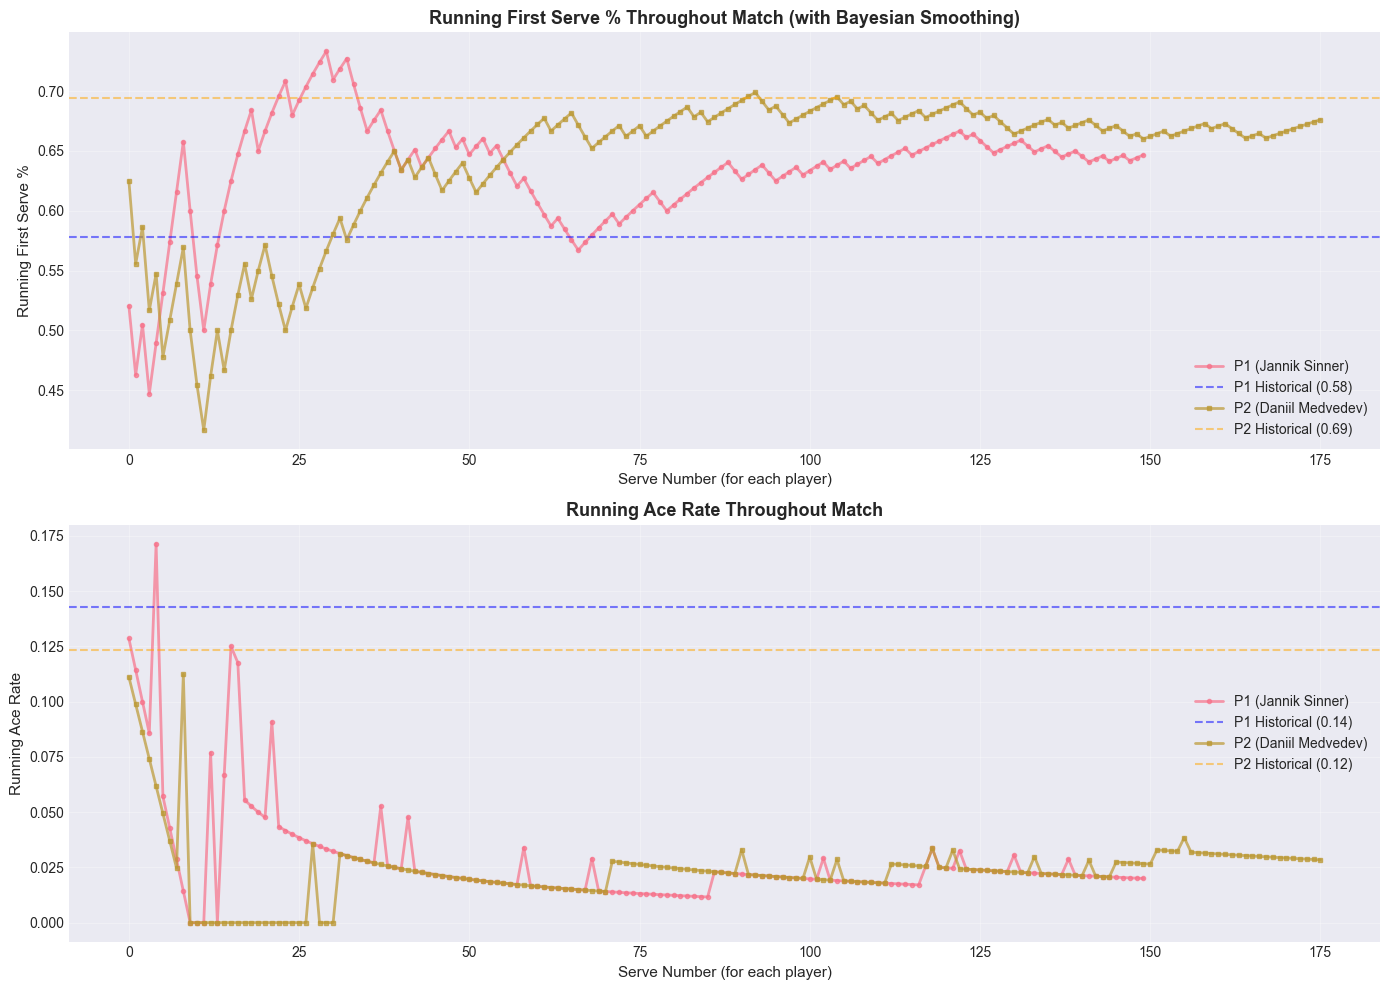

In [8]:
# Plot running first serve % over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Separate by player
p1_points = features_df[features_df['server_id'] == 0].reset_index(drop=True)
p2_points = features_df[features_df['server_id'] == 1].reset_index(drop=True)

# First Serve %
ax = axes[0]
ax.plot(p1_points.index, p1_points['srv_pct'], label=f'P1 ({match_meta["player1"]})', 
        linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.axhline(p1_points['hist_srv_pct'].iloc[0], color='blue', linestyle='--', 
           label=f'P1 Historical ({p1_points["hist_srv_pct"].iloc[0]:.2f})', alpha=0.5)

ax.plot(p2_points.index, p2_points['srv_pct'], label=f'P2 ({match_meta["player2"]})', 
        linewidth=2, marker='s', markersize=3, alpha=0.7)
ax.axhline(p2_points['hist_srv_pct'].iloc[0], color='orange', linestyle='--', 
           label=f'P2 Historical ({p2_points["hist_srv_pct"].iloc[0]:.2f})', alpha=0.5)

ax.set_xlabel('Serve Number (for each player)', fontsize=11)
ax.set_ylabel('Running First Serve %', fontsize=11)
ax.set_title('Running First Serve % Throughout Match (with Bayesian Smoothing)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

# Ace Rate
ax = axes[1]
ax.plot(p1_points.index, p1_points['ace_rate'], label=f'P1 ({match_meta["player1"]})', 
        linewidth=2, marker='o', markersize=3, alpha=0.7)
ax.axhline(p1_points['hist_ace_rate'].iloc[0], color='blue', linestyle='--', 
           label=f'P1 Historical ({p1_points["hist_ace_rate"].iloc[0]:.2f})', alpha=0.5)

ax.plot(p2_points.index, p2_points['ace_rate'], label=f'P2 ({match_meta["player2"]})', 
        linewidth=2, marker='s', markersize=3, alpha=0.7)
ax.axhline(p2_points['hist_ace_rate'].iloc[0], color='orange', linestyle='--', 
           label=f'P2 Historical ({p2_points["hist_ace_rate"].iloc[0]:.2f})', alpha=0.5)

ax.set_xlabel('Serve Number (for each player)', fontsize=11)
ax.set_ylabel('Running Ace Rate', fontsize=11)
ax.set_title('Running Ace Rate Throughout Match', fontsize=13, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

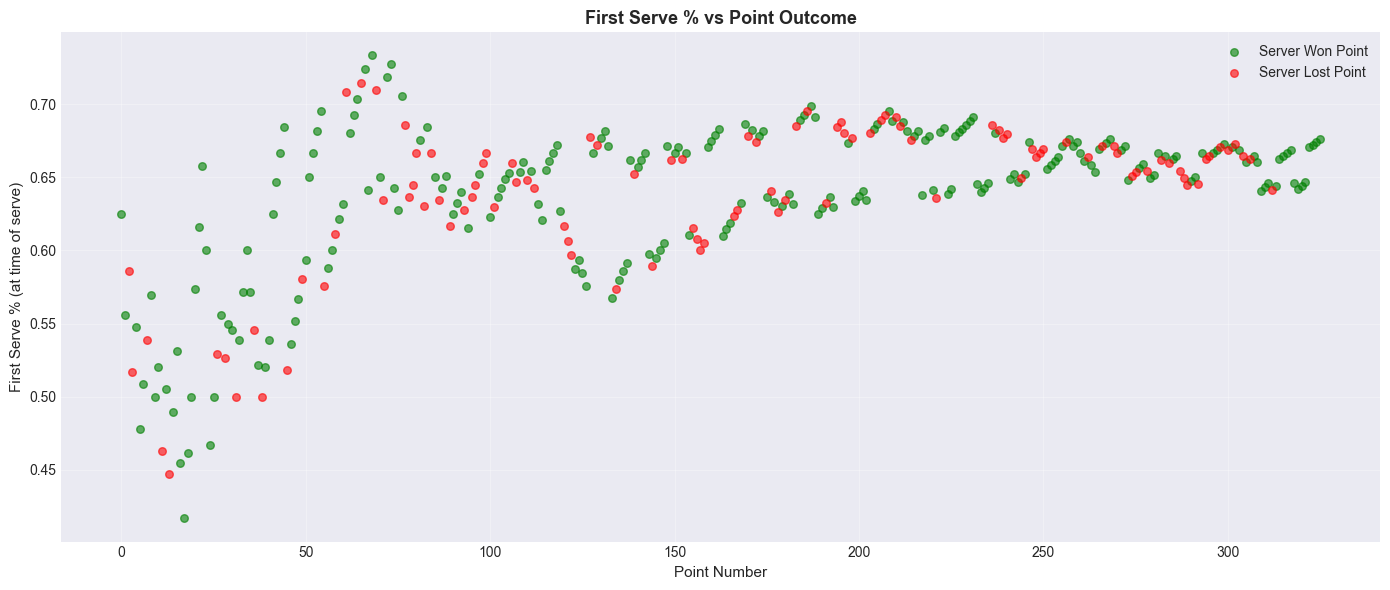

ℹ️  Visual inspection: Does higher first serve % correlate with winning points?


In [9]:
# Overlay point outcomes (won/lost)
fig, ax = plt.subplots(figsize=(14, 6))

# Color points by outcome
won = features_df[features_df['y'] == 1]
lost = features_df[features_df['y'] == 0]

ax.scatter(won.index, won['srv_pct'], c='green', label='Server Won Point', alpha=0.6, s=30)
ax.scatter(lost.index, lost['srv_pct'], c='red', label='Server Lost Point', alpha=0.6, s=30)

ax.set_xlabel('Point Number', fontsize=11)
ax.set_ylabel('First Serve % (at time of serve)', fontsize=11)
ax.set_title('First Serve % vs Point Outcome', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("ℹ️  Visual inspection: Does higher first serve % correlate with winning points?")

## 5. Validate Features (Critical Checks)

In [10]:
print("=" * 80)
print("FEATURE VALIDATION")
print("=" * 80)

# Check 1: All values in [0, 1]
print("\n✅ Check 1: All features in valid range [0, 1]?")
srv_ok = (features_df['srv_pct'] >= 0).all() and (features_df['srv_pct'] <= 1).all()
ace_ok = (features_df['ace_rate'] >= 0).all() and (features_df['ace_rate'] <= 1).all()

if srv_ok and ace_ok:
    print("   PASS: srv_pct and ace_rate within [0, 1]")
else:
    print("   FAIL: Some values out of range!")

# Check 2: No z-scoring applied
print("\n✅ Check 2: Features NOT z-scored (mean ~≠ 0, std ~≠ 1)?")
srv_mean = features_df['srv_pct'].mean()
srv_std = features_df['srv_pct'].std()

if abs(srv_mean) > 0.2 and abs(srv_std - 1.0) > 0.3:
    print(f"   PASS: srv_pct mean = {srv_mean:.3f}, std = {srv_std:.3f}")
    print("   (If z-scored, mean would be ~0 and std ~1)")
else:
    print(f"   WARNING: srv_pct mean = {srv_mean:.3f}, std = {srv_std:.3f}")
    print("   Looks suspiciously like z-scored data!")

# Check 3: Historical baselines are fixed (constant per player)
print("\n✅ Check 3: Historical baselines are fixed constants?")
p1_hist_unique = features_df[features_df['server_id'] == 0]['hist_srv_pct'].nunique()
p2_hist_unique = features_df[features_df['server_id'] == 1]['hist_srv_pct'].nunique()

if p1_hist_unique == 1 and p2_hist_unique == 1:
    print("   PASS: Each player has exactly 1 historical baseline value")
else:
    print(f"   FAIL: P1 has {p1_hist_unique} values, P2 has {p2_hist_unique} values")

# Check 4: Bayesian smoothing applied for early points
print("\n✅ Check 4: Bayesian smoothing visible in early points?")
early_p1 = features_df[features_df['server_id'] == 0].head(10)
if (early_p1['srv_pct'] - early_p1['hist_srv_pct']).abs().max() < 0.3:
    print("   PASS: Early P1 srv_pct close to historical (smoothing working)")
else:
    print("   WARNING: Early values far from historical - check smoothing")

print("\n" + "=" * 80)

FEATURE VALIDATION

✅ Check 1: All features in valid range [0, 1]?
   PASS: srv_pct and ace_rate within [0, 1]

✅ Check 2: Features NOT z-scored (mean ~≠ 0, std ~≠ 1)?
   PASS: srv_pct mean = 0.638, std = 0.054
   (If z-scored, mean would be ~0 and std ~1)

✅ Check 3: Historical baselines are fixed constants?
   PASS: Each player has exactly 1 historical baseline value

✅ Check 4: Bayesian smoothing visible in early points?
   PASS: Early P1 srv_pct close to historical (smoothing working)



## 6. Save Features for Notebook 4

In [11]:
# Save feature matrix
output_path = SRC_DIR / 'features_1501.pkl'
features_df.to_pickle(output_path)

print(f"✅ Features saved to: {output_path}")
print(f"   Shape: {features_df.shape}")
print(f"   Columns: {list(features_df.columns)}")

✅ Features saved to: /Users/egeaydin/Github/TUW2025WS/aip_ege/src/features_1501.pkl
   Shape: (326, 7)
   Columns: ['point_number', 'server_id', 'srv_pct', 'ace_rate', 'hist_srv_pct', 'hist_ace_rate', 'y']


## 7. Summary

In [12]:
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

print(f"\n✅ Engineered {len(features_df)} point-level feature vectors")
print(f"   Features: srv_pct, ace_rate, hist_srv_pct, hist_ace_rate")

print(f"\n✅ Applied Bayesian smoothing for first 10 serves")
print("   Prevents noise from early-point instability (1/1, 0/1, etc.)")

print(f"\n✅ All features on natural 0-1 scale (NO z-scoring)")
print("   Ensures dimensional consistency with historical baselines")

print(f"\n✅ Ready for Bayesian model in Notebook 4")
print("   Deviation calculation: srv_pct - hist_srv_pct (both on 0-1 scale)")

print("\n📋 NEXT STEPS:")
print("   → Notebook 4: Build PyMC Bayesian logistic regression")
print("   → Use srv_deviation and ace_deviation as predictors")
print("   → Run sequential inference to track posterior convergence")

print("\n" + "=" * 80)

FEATURE ENGINEERING SUMMARY

✅ Engineered 326 point-level feature vectors
   Features: srv_pct, ace_rate, hist_srv_pct, hist_ace_rate

✅ Applied Bayesian smoothing for first 10 serves
   Prevents noise from early-point instability (1/1, 0/1, etc.)

✅ All features on natural 0-1 scale (NO z-scoring)
   Ensures dimensional consistency with historical baselines

✅ Ready for Bayesian model in Notebook 4
   Deviation calculation: srv_pct - hist_srv_pct (both on 0-1 scale)

📋 NEXT STEPS:
   → Notebook 4: Build PyMC Bayesian logistic regression
   → Use srv_deviation and ace_deviation as predictors
   → Run sequential inference to track posterior convergence

